### Code block 1: Package initialization
Import required packages, do not change.

In [47]:
import argparse
import os, sys
import time
import datetime
import math
import numpy as np
import matplotlib.pyplot as plt

# Import pytorch dependencies
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.nn.modules.utils import _single, _pair, _triple


### Code block 2: Useful classes
Customized implementation of [nn.Conv2d](https://pytorch.org/docs/stable/generated/torch.nn.Conv2d.html) and [nn.Linear](https://pytorch.org/docs/stable/generated/torch.nn.Linear.html#torch.nn.Linear), do not change.

In [48]:
class CONV(nn.Conv2d):
    def __init__(self, in_channels, out_channels, kernel_size, stride=1,
                 padding=0, dilation=1, groups=1,
                 bias=False, padding_mode='zeros'):
        self.input = None
        self.output = None
        kernel_size = _pair(kernel_size)
        stride = _pair(stride)
        padding = _pair(padding)
        dilation = _pair(dilation)
        super(CONV, self).__init__(
            in_channels, out_channels, kernel_size, stride, padding, dilation, 
            groups, bias, padding_mode)
    
    def forward(self, input):
        self.input = input
        # 'pytorch 2.0'
        self.output = super().forward(input)
        return self.output
    
class FC(nn.Linear):
    def __init__(self, in_features, out_features, bias=True):
        self.input = None
        self.output = None
        super(FC, self).__init__(in_features, out_features, bias)
    
    def forward(self, input):
        self.input = input
        self.output = F.linear(input, self.weight, self.bias)
        return self.output

## Lab 2

### Code block 3: SimpleNN implementation

Please follow the instructions in Lab 2(a) and fill in the code in the lines marked **Your code here**

In [49]:
""" 
Lab 2(a)
Build the SimpleNN model by following Table 1
"""

# Create the neural network module: LeNet-5
class SimpleNN(nn.Module):
    def __init__(self):
        super(SimpleNN, self).__init__()
        # Layer definition
        self.conv1 = CONV(in_channels=3, out_channels=16, kernel_size=5, stride=1, padding=2)
        self.pool1 = nn.MaxPool2d(kernel_size=4, stride=2, padding=0)
        self.conv2 = CONV(in_channels=16, out_channels=16, kernel_size=3, stride=1, padding=2)
        self.pool2 = nn.MaxPool2d(kernel_size=3, stride=2, padding=0)
        self.conv3 = CONV(in_channels=16, out_channels=32, kernel_size=7, stride=1, padding=2)
        self.pool3 = nn.MaxPool2d(kernel_size=2, stride=2, padding=0)
        self.fc1   = FC(in_features=3*3*32, out_features=32)
        self.fc2   = FC(in_features=32, out_features=10)

    def forward(self, x):
        # Forward pass computation
        # Conv 1
        x = F.relu(self.conv1(x))
        # MaxPool
        x = self.pool1(x)
        # Conv 2
        x = F.relu(self.conv2(x))
        # MaxPool
        x = self.pool2(x)
        # Conv 3
        x = F.relu(self.conv3(x))
        # MaxPool
        x = self.pool3(x)
        # Flatten
        x = x.view(x.size(0), -1)
        # FC 1
        x = F.relu(self.fc1(x))
        # FC 2
        out = F.relu(self.fc2(x))
        return out

# GPU check                
device = 'cuda' if torch.cuda.is_available() else 'cpu'
if device =='cuda':
    print("Run on GPU...")
else:
    print("Run on CPU...")

# Model Definition  
net = SimpleNN()
net = net.to(device)

# Test forward pass
data = torch.randn(5,3,32,32)
data = data.to(device)
# Forward pass "data" through "net" to get output "out" 
out = net.forward(data)    #Your code here

# Check output shape
assert(out.detach().cpu().numpy().shape == (5,10))
print("Forward pass successful")

Run on CPU...
Forward pass successful


### Code block 4: Shape observation
Please follow the instructions in Lab 2(a) and fill in the code in the lines marked **Your code here**. Gather the printed results in Table 2 in your report.

**ANSWER:**

Input feature map $C_1 \times H_1 \times W_1$, output $C_2 \times H_2 \times W_2$, kernel size: $K \times K$
 
Total weight elements for convolutional layer: $C_2 \times C_1 \times K \times K$

Total weight elements for fully connected layer (not considering bias term): $Input \times Output$

Total MACs for convolutional layer: $C_1 \times K \times K \times C_2 \times H_2 \times W_2 $

Total MACs for fully connected layer (not considering bias term): $Input \times Output$

In [51]:
"""
Lab 2(b)
"""
# Forward pass of a single image
data = torch.randn(1,3,32,32).to(device)
# Forward pass "data" through "net" to get output "out" 
out =  net.forward(data)   #Your code here

# Iterate through all the CONV and FC layers of the model
for name, module in net.named_modules():
    if isinstance(module, CONV) or isinstance(module, FC):
        # Get the input feature map of the module as a NumPy array
        input = module.input     
        # Get the output feature map of the module as a NumPy array
        output = module.output     
        # Get the weight of the module as a NumPy array
        weight = module.weight     
        # Compute the number of parameters in the weight
        num_Param = module.weight.nelement()     
        # Compute the number of MACs in the layer
        if isinstance(module, CONV):
            num_MAC = module.kernel_size[0] * module.kernel_size[1] * input.shape[1] * \
                output.shape[1] * output.shape[2] * output.shape[3]
        else:
            num_MAC = weight.shape[0] * weight.shape[1]
        print(f'{name:10} {str(input.shape):20} {str(output.shape):20} {str(weight.shape):20} {str(num_Param):10} {str(num_MAC):10}')


conv1      torch.Size([1, 3, 32, 32]) torch.Size([1, 16, 32, 32]) torch.Size([16, 3, 5, 5]) 1200       1228800   
conv2      torch.Size([1, 16, 15, 15]) torch.Size([1, 16, 17, 17]) torch.Size([16, 16, 3, 3]) 2304       665856    
conv3      torch.Size([1, 16, 8, 8]) torch.Size([1, 32, 6, 6]) torch.Size([32, 16, 7, 7]) 25088      903168    
fc1        torch.Size([1, 288]) torch.Size([1, 32])  torch.Size([32, 288]) 9216       9216      
fc2        torch.Size([1, 32])  torch.Size([1, 10])  torch.Size([10, 32]) 320        320       


## Lab 3 (Bonus)

### Code block 5: Initial weight histogram
Please follow the instructions in Lab 3(a) and fill in the code in the lines marked **Your code here**. Copy the output figures into your report.

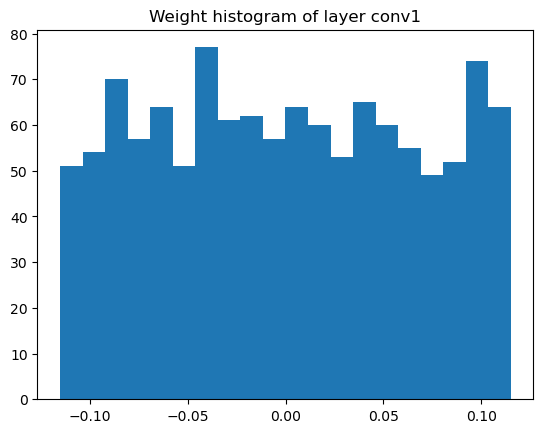

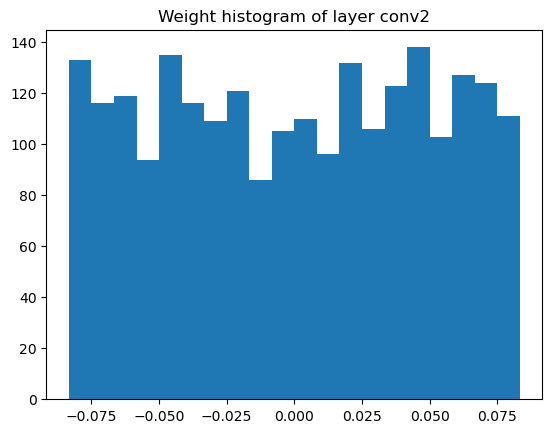

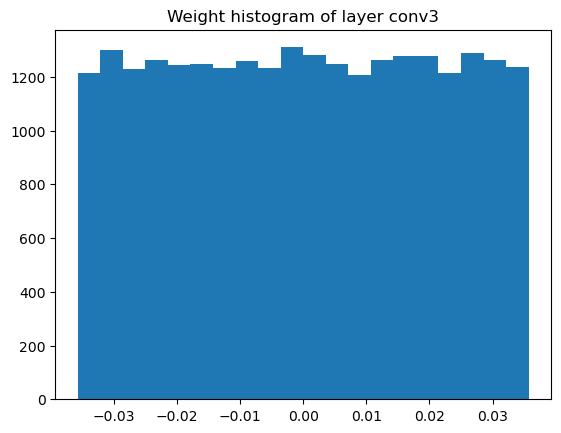

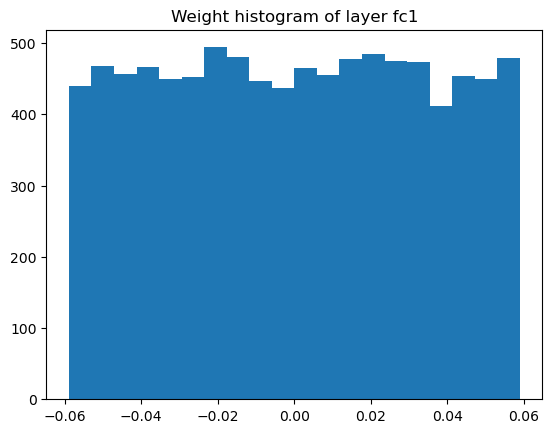

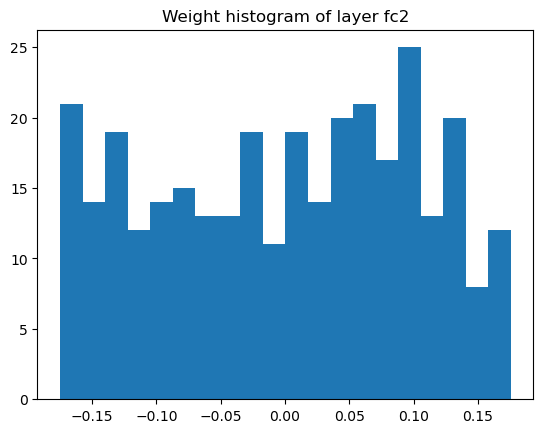

In [52]:
"""
Lab 3(a)
"""
for name, module in net.named_modules():
    if isinstance(module, CONV) or isinstance(module, FC):
        # Get the weight of the module as a NumPy array
        weight = module.weight.detach().numpy()     
        
        # Reshape for histogram
        weight = weight.reshape(-1)
        _ = plt.hist(weight, bins=20)
        plt.title("Weight histogram of layer "+name)
        plt.show()

### Code block 6: Gradient histogram
Please follow the instructions in Lab 3(b) and fill in the code in the lines marked **Your code here**. Copy the output figures into your report.

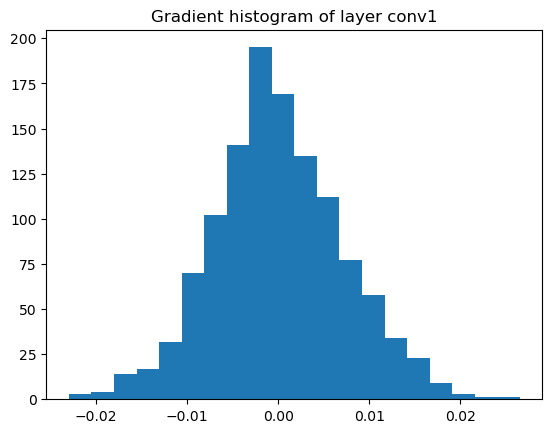

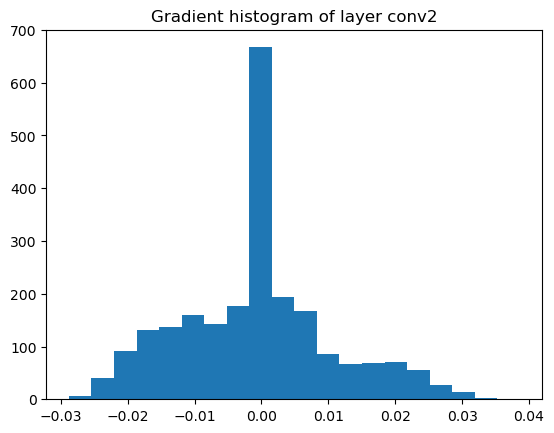

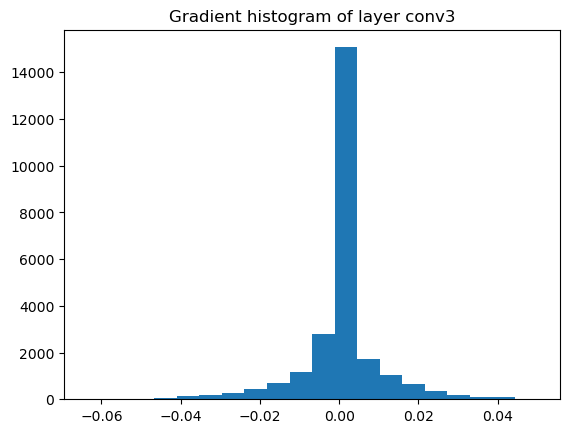

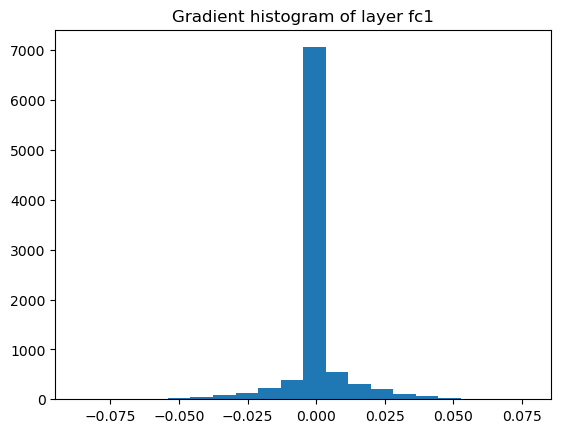

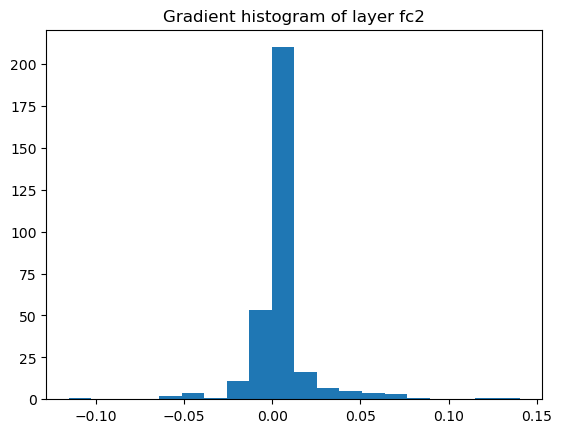

In [53]:
'''
Lab 3(b)
'''
# Loss definition
criterion = nn.MSELoss()
# Random target
target = torch.randn(1, 10).to(device)

# Loss computation
loss = criterion(target, output)
# Backward pass for gradients
loss.backward()

for name, module in net.named_modules():
    if isinstance(module, CONV) or isinstance(module, FC):
        # Get the gradient of the module as a NumPy array
        gradient = module.weight.grad.detach().numpy()
        
        # Reshape for histogram
        gradient = gradient.reshape(-1)
        _ = plt.hist(gradient, bins=20)
        plt.title("Gradient histogram of layer "+name)
        plt.show()


### Code block 7: Zero initialization?
Please follow the instructions in Lab 3(c) and fill in the code in the lines marked **Your code here**. Copy the output figures into your report.

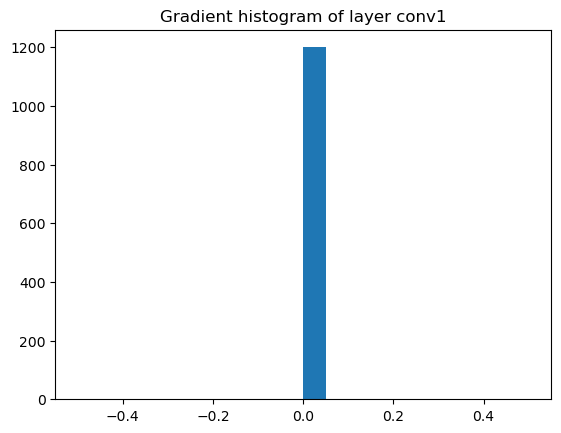

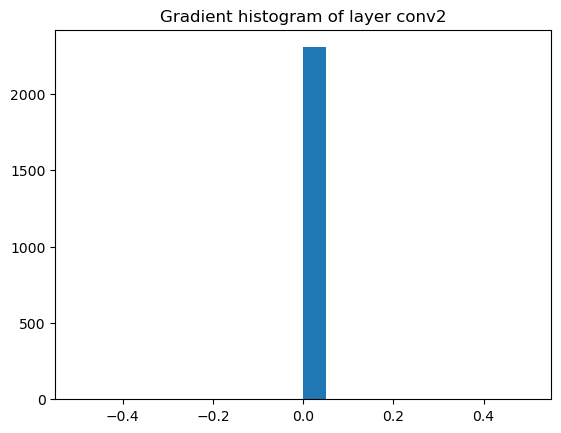

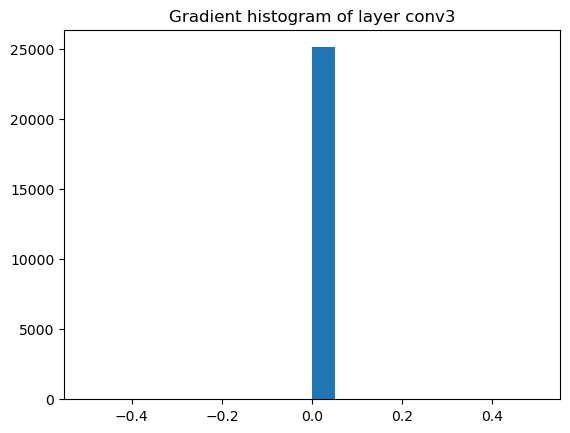

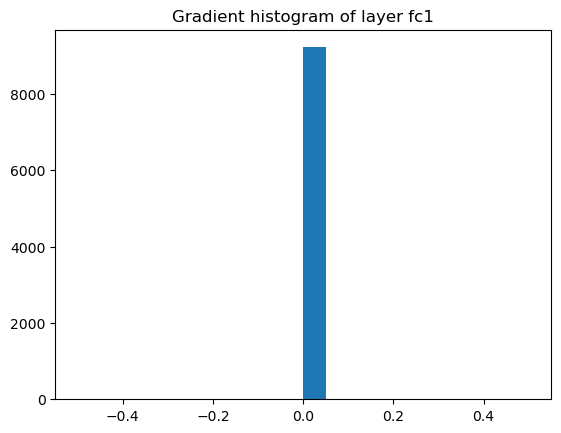

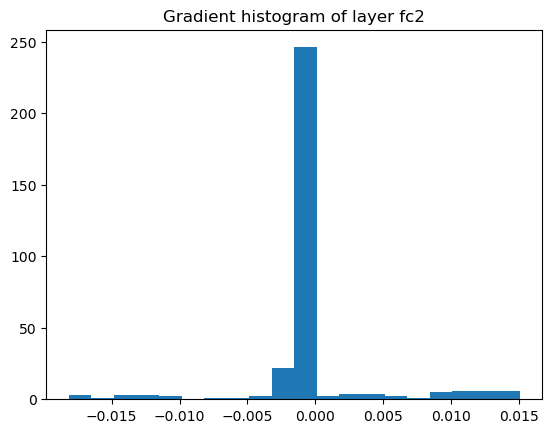

In [54]:
'''
Lab 3(c)
'''
# Set model weights to zero
for name, module in net.named_modules():
    if isinstance(module, CONV) or isinstance(module, FC):
        # Set the weight of each module to all zero
        module.weight.data.zero_()
        # if module.bias is not None:
        #     module.bias.data.zero_()

# Reset gradients
net.zero_grad()
        
# Forward and backward pass
# Random data and target
data = torch.randn(1,3,32,32).to(device)
target = torch.randn(1, 10).to(device)

# Forward pass
out = net(data)
# Loss computation
loss = criterion(out, target)
# Backward pass
loss.backward()

for name, module in net.named_modules():
    if isinstance(module, CONV) or isinstance(module, FC):
        # Get the gradient of the module as a NumPy array
        gradient = module.weight.grad.detach().numpy()
        
        # Reshape for histogram
        gradient = gradient.reshape(-1)
        _ = plt.hist(gradient, bins=20)
        plt.title("Gradient histogram of layer "+name)
        plt.show()